## Forschung und Entwicklungsprojekt
### **Titel**: *Rekonstruktion von Hypernym-Taxonomien mittels LLMs im Vergleich zu menschlichen linguistischen Wortnetzen*
---
### **Autor**: *Safouan Er-Ryfy*

### Projektziel
> Das Ziel dieses Projekts ist es, Hypernym-Taxonomien mithilfe von Large Language Models (LLMs) – insbesondere LLaMA 3.1 – zu rekonstruieren. Die dabei automatisch generierten Taxonomien werden mit linguistischen Wortnetzen wie GermaNet verglichen. Als Grundlage dienen Begriffe aus dem deutschsprachigen E-Mail-Korpus CodEAlltag.
Die zentrale Fragestellung lautet:   
Können LLMs wie LLaMA 3.1 bessere oder gleichwertige Hypernym-Taxonomien liefern wie klassische Wortnetze?


## Installation & Imports

In [ ]:
%%capture
!pip install accelerate huggingface_hub sentence_transformers
!python -m spacy download de_core_news_md
!pip install germanetpy

In [ ]:
import torch
import transformers
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from collections import Counter
import re
from germanetpy.germanet import Germanet
from huggingface_hub import notebook_login
from google.colab import data_table
data_table.enable_dataframe_formatter()
from tqdm.auto import tqdm
tqdm.pandas()

## Methodik

### Hypernymbestimmung mit LLaMA
> Mit LLaMA 3.1 werden Hypernym-Beziehungen für verschiedene Begriffe prompt-basiert generiert. Dabei wird untersucht, ob das Modell sinnvolle Ketten bzw. Hierarchien erzeugt und ob durch den Einsatz einer probabilistischen Methode – also durch mehrfaches Abfragen des Modells – die Qualität der Ergebnisse verbessert werden kann.

### Laden des Models
> Bevor wir das Sprachmodell nutzen können, muss ein Hugging Face Token eingegeben werden, um auf das Modell zuzugreifen. Falls noch kein Token vorhanden ist, kann er unter folgendem Link erstellt werden:  [Hugging Face Access Tokens](https://huggingface.co/settings/tokens)

In [ ]:
notebook_login() # In den Fenster eingeben

> Das Meta-LLaMA-3.1-8B-Instruct-Modell wird eingerichtet, um Texte zu generieren. Bevor es genutzt werden kann, muss der Zugriff auf Hugging Face freigeschaltet werden:  [Meta LLaMA 3.1-8B Instruct auf Hugging Face](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)

In [ ]:
%%time
model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
pipeline = transformers.pipeline(
"text-generation",
      model=model,
      torch_dtype=torch.float16,
      device_map="auto"
)
pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id[0]
pipeline.tokenizer.padding_side = "left"

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


CPU times: user 39.6 s, sys: 1min 25s, total: 2min 5s
Wall time: 1min


### Datensatz: CodeAlltag E-Mails
> Ein Experiment wird mit E-Mails aus dem CodEAlltag-Korpus ([GitHub](https://github.com/codealltag/CodEAlltag_pS)) durchgeführt. Zunächst werden dabei *Intent-Action-Object-Paare* aus den E-Mails identifiziert. Anschließend wird LLaMA eingesetzt, um für die extrahierten Objekte passende Hypernyme zu generieren. Ziel ist es, übergeordnete Begriffe zu ermitteln – zum Beispiel: *E-Mail* → *Nachricht* → *Information*.

In [ ]:
!git clone https://github.com/codealltag/CodEAlltag_pS

Cloning into 'CodEAlltag_pS'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (811/811), done.
remote: Compressing objects: 100% (778/778), done.
remote: Total 811 (delta 1), reused 799 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (811/811), 333.39 KiB | 6.41 MiB/s, done.
Resolving deltas: 100% (1/1), done.


> Das [spaCy-Modell](https://spacy.io/models/de/#de_core_news_md) wird geladen, um die E-Mails aus dem CodEAlltag-Ordner zu verarbeiten. Dabei werden die Dateinamen und Inhalte erfasst, in einer Tabelle gespeichert und übersichtlich nach Namen sortiert.

In [ ]:
# Das deutsche spaCy-Model
nlp = spacy.load("de_core_news_md")
# Filter Inhalt
dictionary = {}
file_names = []
file_texts = []
os.chdir('/content/CodEAlltag_pS/emails')
for file_name in os.listdir('.'):
  if '.txt' in file_name:
    f = open(file_name, "r", encoding="utf-8")
    text = f.read()
    file_names.append(file_name)
    file_texts.append(text)

dictionary["file_names"] = file_names
dictionary["file_texts"] = file_texts

df = pd.DataFrame.from_dict(dictionary).sort_values(by=['file_names'])
print("Shape: ", df.shape)

Shape:  (800, 2)


### Intent-Action-Object
> Jede E-Mail wird vom Modell analysiert und mit einem Prompt versehen, der ein Action-Object-Paar als zentrale Aufgabe für den Empfänger identifizieren soll. Die Nachrichten werden dabei durch eine Pipeline verarbeitet, die sie nach einem festen Muster auswertet. Anschließend werden die erkannten Aktions- und Objektwörter lemmatisiert. Je nach Struktur und Formulierung der E-Mail kann es dabei gelegentlich zu Verzerrungen in den extrahierten Beispielen kommen.

In [ ]:
%%capture
pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.pad_token_id
messages = []

for i in range(len(df)):
    messages.append([
        {
            "role": "system",
            "content": """
            Extrahiere aus der neuesten E-Mail an den Empfänger die Aktion (Verb im Infinitiv) und das Objekt (Substantiv).

            Format: [AKTION, OBJEKT]
            Keine Erklärungen oder Zusatzinfos.

            Regeln:
            - Die Antwort muss auf Deutsch sein und das Objekt ein Substantiv sein.
            - Falls keine klare Aufgabe bzw. passende [AKTION, OBJEKT] erkennbar ist, bitte: [UNBEKANNT, UNBEKANNT] zurückgeben.

            Beispiele:
            [antworten, E-Mail]
            [halten, Votrag]
            [senden, Dokument]
            [anmelden, Projekt]
            [weiterleiten, Info]
            """
        },
        {
            "role": "user",
            "content": "\n\"" + str(df.iloc[i]["file_texts"]) + "\""
        }
    ])

outputs = pipeline(
        messages,
        max_new_tokens=256,
        batch_size=4
    )

df["json"]=""
for i in range(len(outputs)):
  df["json"].iloc[i] = outputs[i][0]["generated_text"][-1]["content"].strip()

# Extrahiere die Aktions- und Objekt-Wörter aus dem JSON-Ergebnis
df[['Action', 'Object']] = df['json'].str.replace(']', '').str.replace('[', '').str.split(',', n=1, expand=True)

# Hilfsfunktion zur Lemmatisierung von Wörtern
def lemmatize_word(word):
    if pd.isna(word):
        return word
    doc = nlp(word)
    if doc:
        # Falls kein Lemma gefunden wurde, gib das Originalwort zurück
        return doc[0].lemma_ if doc[0].lemma_ != word else word
    return word

# Wende Lemmatisierung auf die extrahierten Wörter an
df['Action']= df['Action'].str.strip()
df['Object']= df['Object'].str.strip()
df['actionlemma'] = df['Action'].progress_apply(lemmatize_word)
df['objectlemma'] = df['Object'].progress_apply(lemmatize_word)

In [ ]:
# Ein Beispiel zeigen
df.head(1)

,file_names,file_texts,json,Action,Object,actionlemma,objectlemma
263,100_0.txt,Sehr geehrter Herr Kilic!\n\nIch bin Sudentin ...,"[weiterhelfen, Arbeit]",weiterhelfen,Arbeit,weiterhelfen,Arbeit


> Es wird untersucht, wie viele der CodEAlltag-E-Mails vom LLaMA-Modell bereits als „UNBEKANNT“ gekennzeichnet wurden. Diese Markierung erfolgt, wenn sich aus dem Inhalt der E-Mail keine eindeutige Anweisung ableiten lässt – wie es im Prompt vorgesehen ist. Auf diese Weise wird geprüft, ob das Modell die Anweisungen im Prompt korrekt umsetzt.

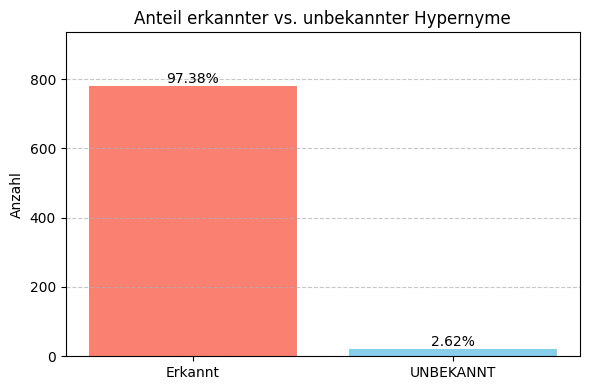

In [ ]:
def plot_unknown_distribution(df, column):
    """
    Erstellt ein Balkendiagramm mit Prozentanzeige, das zeigt, wie viele Einträge als 'UNBEKANNT'
    markiert wurden im Vergleich zu erkannten Hypernymen.

    :param df: DataFrame mit einer Spalte, in der Hypernyme oder 'UNBEKANNT' gespeichert sind.
    :param column: Spaltenname, der analysiert werden soll.
    :return: Series mit absoluten und prozentualen Häufigkeiten.
    """
    # 'UNBEKANNT' vs. 'Erkannt'
    classified = df[column].apply(lambda x: "UNBEKANNT" if x == "UNBEKANNT" else "Erkannt")
    value_counts = classified.value_counts()
    percentages = (value_counts / value_counts.sum() * 100).round(2)

    # Balkendiagramm
    plt.figure(figsize=(6, 4))
    bars = plt.bar(value_counts.index, value_counts.values, color=['salmon', 'skyblue'])

    # Prozentwerte
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{percent}%", ha='center', va='bottom', fontsize=10)

    plt.title("Anteil erkannter vs. unbekannter Hypernyme")
    plt.ylabel("Anzahl")
    plt.xticks(rotation=0)
    plt.ylim(0, value_counts.max() * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_unknown_distribution(df, column="Object")

### Hypernym
> Jedes lemmatisierte Wort wird fünfmal vom Modell nach passenden Hypernymen abgefragt, um eine Wahrscheinlichkeitsverteilung zu erzeugen. Darauf aufbauend wird eine Hypernym-Kette mit einer festgelegten Tiefe erstellt, indem iterativ das jeweils häufigste übergeordnete Wort ergänzt wird – bis entweder die maximale Tiefe erreicht ist oder keine neuen Hypernyme mehr gefunden werden.
Die weitere Verarbeitung erfolgt ausschließlich für das Objekt des zuvor identifizierten Intent-Action-Object-Paares. Während Action und Object zunächst zur Intent-Erkennung herangezogen wurden, wird für die Generierung der Hypernym-Kette nur das Objekt berücksichtigt.

In [ ]:
def extract_hypernyms(unique_values):
    """
    Übergeordnete Begriffe (Hypernyme) für eine Liste deutscher Wörter werden mithilfe des LLaMA-Modells ermittelt.

    :param unique_values: Liste mit Wörtern, für die passende Oberbegriffe gesucht werden.
    :return: DataFrame mit den häufigsten ermittelten Hypernymen pro Wort.
    """
    unique_values = [u for i in range(5) for u in unique_values]  # Für mehrfaches Befragen des LLMs
    messages = []
    for i in range(len(unique_values)):
      messages.append([
          {
              "role": "system",
              "content": f"""
              Du bist ein Linguistik-Experte mit tiefgehendem Wissen über Semantik und Wortbedeutungen.
              Bestimme die übergeordneten Hypernyme für das gegebene deutsche Wort.

              Anforderungen:
              - Gib mehrere Hypernyme an, getrennt durch ein Komma.
              - Die Antwort muss auf Deutsch sein.
              - Keine zusätzlichen Erklärungen, Formatierungen oder Beispiele.

              Beispiele:
              - Eingabe: Information
              - Ausgabe: Kommunikationseinheit, Einheit, Entität

              - Eingabe: Klausur
              - Ausgabe: Examen, Prüfung, Leistung

              - Eingabe: Mitarbeiter
              - Ausgabe: Berufstätiger, Person, Lebewesen

              - Eingabe: Mail
              - Ausgabe: Nachricht, Mitteilung, Senden
              """
          },
          {
              "role": "user",
              "content": f"\"{unique_values[i]}\""
          }
      ])

    outputs = pipeline(
      messages,
      max_new_tokens=256,
      batch_size=4
  )

    columns = ['subword', 'batch', 'parent']
    res = []
    for i in range(len(outputs)):
        parents = outputs[i][0]["generated_text"][-1]["content"].strip().split(',')
        for k in range(len(parents)):
            # 99 als Platzhalter für Batch
            res.append([unique_values[i], 99, parents[k].strip()])
    res = pd.DataFrame(res, columns=columns)

    # Calculate word counts for each parent
    resgroup = res.groupby(['subword', 'parent']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
    resgroup = resgroup.loc[resgroup.groupby('subword')['Count'].idxmax()]
    return resgroup

def build_hypernym_chain(word, resgroup, max_depth):
    """
    Für ein gegebenes Wort wird eine Hypernym-Kette erstellt, indem iterativ nach übergeordneten Begriffen gesucht wird.

    :param word: Das Wort, für das eine Hypernym-Kette gebildet wird.
    :param resgroup: DataFrame mit bekannten Hypernym-Zuordnungen.
    :param max_depth: Maximale Anzahl an Hypernym-Stufen.
    :return: Eine Zeichenkette mit der Hypernym-Kette, getrennt durch ", ".
    """
    chain = [word]
    if word != "UNBEKANNT": # Wörter ohne erkannte Hypernyme werden herausgefiltert
        current_word = word
        for _ in range(max_depth):
            # Für iterative Anrufe für den CHain
            hypernym_data = extract_hypernyms([current_word])
            # Häufigste Hypernym
            hypernym_data = hypernym_data[hypernym_data['subword'] == current_word]

            if not hypernym_data.empty:
                most_common_parent = hypernym_data.iloc[0]['parent']
                if most_common_parent not in chain:
                    chain.append(most_common_parent)
                    current_word = most_common_parent
                else:
                    break # Cycle
            else:
                break  # Keine Hypernyme

    return " , ".join(chain)

In [ ]:
# Nur Objekte betrachten
input_words = df.objectlemma.dropna().unique()
resgroup = extract_hypernyms(input_words)

In [ ]:
resgroup.shape

(421, 3)

> Im Folgenden wird mit den eindeutigen Werten gearbeitet, da doppelte Einträge bereits zusammengefasst wurden. Dadurch ist die Anzahl der zu bearbeitenden E-Mails entsprechend gesunken.

In [ ]:
chains = []
for word in tqdm(input_words):
    chain = build_hypernym_chain(word, resgroup, max_depth=5)
    chains.append({"Word": word, "Hypernym_Chain": chain})

  0%|          | 0/421 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


> Die Hypernym-Ketten werden bereinigt, indem das Ausgangswort entfernt und die Kette von einer Zeichenkette in eine Liste umgewandelt wird.

In [ ]:
def filter_hypernyms(df):
    filtered_df = df.copy()
    for index, row in df.iterrows():
        word = row['Word']
        hypernyms = row['Hypernym_Chain']
        filtered_hypernyms = [h for h in hypernyms if h != word]
        filtered_df.loc[index, 'Hypernym_Chain'] = filtered_hypernyms
    return filtered_df
def hypernym_chain(df_chains):
    df_chains['Hypernym_Chain'] = df_chains['Hypernym_Chain'].str.split(' , ')
    return df_chains
df_chains = pd.DataFrame(chains)
df_hypernyms = hypernym_chain(df_chains)
df_chain = filter_hypernyms(df_hypernyms)

In [ ]:
# Hypernym-Kette - Beispiele
df_chain.head(5)

,Word,Hypernym_Chain
0,Arbeit,"[Tätigkeit, Aktivität, Prozess, Ablauf, Entwic..."
1,Hospitation,"[Praktikum, Ausbildung, Bildung]"
2,Hilfe,[Unterstützung]
3,Mail,"[Kommunikation, Austausch]"
4,Mutter,"[Elternteil, Familienmitglied, Verwandter]"


## Quantitativer Vergleich mit GermaNet

> Die GermaNet-API ([GitHub](https://github.com/Germanet-sfs/germanetpy)) ermöglicht den Zugriff auf das deutsche WordNet, in dem Nomen, Verben und Adjektive semantisch miteinander verknüpft sind. Bedeutungsähnliche Wörter werden in sogenannten *Synsets* gruppiert und über verschiedene Relationen miteinander verbunden.
Zur Bewertung der generierten Hypernyme wird ein Vergleich mit den Einträgen aus GermaNet durchgeführt. So kann eingeschätzt werden, wie gut das Sprachmodell im Vergleich zu einer linguistisch kuratierten Ressource abschneidet.
Für die Nutzung von GermaNet ist eine *Lizenz* erforderlich, die über die [Lizenzseite der Universität Tübingen](https://uni-tuebingen.de/fakultaeten/philosophische-fakultaet/fachbereiche/neuphilologie/seminar-fuer-sprachwissenschaft/arbeitsbereiche/allg-sprachwissenschaft-computerlinguistik/ressourcen/lexica/germanet-1/lizenzen/) beantragt werden kann. Nach Erhalt der Zugangsdaten können die Inhalte aus *`GN_V190_XML`* beispielsweise in den *`data/`*-Ordner eines Google-Colab-Projekts hochgeladen werden.

> Anschließend lässt sich GermaNet wie folgt laden:

In [ ]:
# GermaNet- Daten
%%capture
germanet = Germanet("/content/data") # Pfad zu den entpackten XML-Dateien

In [ ]:
# Beispiel
hyponym = "Projekt"
synsets = germanet.get_synsets_by_orthform(hyponym)
synsets

[Synset(id=s19848, lexunits=Projekt)]

In [ ]:
synset = germanet.get_synset_by_id('s19848')
synset.direct_hypernyms

{Synset(id=s19757, lexunits=Aufgabe)}

In [ ]:
synset.all_hypernyms()

{Synset(id=s13123, lexunits=Attribut, Eigenschaft, Merkmal, Feature, Spezifikum),
 Synset(id=s13219, lexunits=Qualität, Beschaffenheit),
 Synset(id=s13220, lexunits=Qualität einer Sache),
 Synset(id=s13928, lexunits=Verwendungsattribut),
 Synset(id=s13994, lexunits=Notwendigkeit),
 Synset(id=s19723, lexunits=Pflicht, Verpflichtung),
 Synset(id=s19757, lexunits=Aufgabe),
 Synset(id=s51001, lexunits=GNROOT)}

> Die *Breadth-First Search* (BFS) ist ein Verfahren zur ebenenweisen Durchsuchung von Knoten. Dabei wird eine Warteschlange (*Queue*) verwendet, um Begriffe zunächst auf derselben Ebene zu verarbeiten, bevor in höhere Ebenen übergegangen wird. In diesem Projekt wird BFS eingesetzt, um alle Synsets eines Wortes sowie deren übergeordnete Hypernyme systematisch zu erfassen. Eine anschauliche Einführung bietet dieser [Blogartikel](https://medium.com/@tahsinsoyakk/breadth-first-search-bfs-a-comprehensive-guide-4672bbc5e48c).

In [ ]:
def get_hypernym_chain_with_hops(word, germanet):
    """
    Für ein gegebenes Wort werden Hypernym-Ketten aus GermaNet erstellt, indem alle direkten übergeordneten Begriffe
    für sämtliche Bedeutungen (Synsets) schrittweise ermittelt werden.

    :param word: Das Wort, für das die Hypernym-Ketten bestimmt werden sollen.
    :param germanet: GermaNet-Instanz zur Abfrage der Synsets und Hypernyme.
    :return: Ein DataFrame mit allen möglichen Hypernym-Beziehungen, einschließlich Synset-IDs und Rangstufen.
    """
    synsets = germanet.get_synsets_by_orthform(word)

    if not synsets:
        return pd.DataFrame(columns=["synset_id", "hyponym", "hypernym_id", "hypernym", "hop", "synset_index"])

    chain_data = []

    # BFS-Queue mit Hop-Level
    for synset_index, synset in enumerate(synsets):
        queue = [(synset, 1)]  # Start mit dem Ursprungs-Synset auf Ebene 1

        visited = set()

        while queue:
            current_synset, hop = queue.pop(0) # Nächstes Synset aus der Warteschlange holen
            if current_synset.id in visited:
                continue
            visited.add(current_synset.id)

            hypernyms = list(current_synset.direct_hypernyms)

            for hypernym in hypernyms:
                chain_data.append([
                    current_synset.id,
                    ", ".join([lu.orthform for lu in current_synset.lexunits]),
                    hypernym.id,
                    ", ".join([lu.orthform for lu in hypernym.lexunits]),
                    hop,
                    synset_index
                ])
                if not hypernym.is_root():
                    # Speichern und weiter in die Warteschlange legen
                    queue.append((hypernym, hop + 1))

    df = pd.DataFrame(chain_data, columns=["synset_id", "hyponym", "hypernym_id", "hypernym", "hop", "synset_index"])
    df = df.sort_values(by=["synset_index", "hop"]).reset_index(drop=True)

    return df

def process_germanet_hypernyms(df_germanet):
    """
    Die Hypernym-Kette aus GermaNet wird bereinigt und in eine strukturierte Form gebracht.

    :param df_germanet: DataFrame mit den ursprünglichen Hypernym-Ketten aus GermaNet.
    :return: Ein bereinigter DataFrame mit der Hypernym-Kette in strukturierter Form.
    """
    df_germanet["hypernym"] = df_germanet["hypernym"].astype(str).apply(
        lambda x: x.split(",") if x not in ["nan", "None"] else []
    )
    df_germanet["hypernym"] = df_germanet["hypernym"].apply(
        lambda lst: [word.strip(" []'\"") for word in lst]
    )

    # Explodieren der Hypernym-Kette
    df_expanded = df_germanet.explode("hypernym").reset_index(drop=True)

    # Beibehaltung des Hop-Wertes für alle Hypernyme derselben Stufe
    df_expanded = df_expanded.rename(columns={
        "hypernym": "GermaNet Hypernym",
        "hyponym": "Hyponym",
        "hop": "GermaNet Rang"
    })

    return df_expanded

def process_llama_hypernyms(df_llama):
    """
    Die Hypernym-Kette aus dem LLaMA-Modell wird bereinigt und in eine strukturierte Form gebracht.

    :param df_llama: DataFrame mit den ursprünglichen Hypernym-Ketten aus dem LLaMA-Modell.
    :return: Ein bereinigter DataFrame mit der Hypernym-Kette in strukturierter Form.
    """
    df_llama["Llama Hypernym"] = df_llama["Llama Hypernym"].astype(str).apply(
        lambda x: x.split(",") if x not in ["nan", "None"] else []
    )
    df_llama["Llama Hypernym"] = df_llama["Llama Hypernym"].apply(
        lambda lst: [word.strip(" []'\"") for word in lst]
    )

    # Explodieren der Hypernym-Kette
    df_expanded = df_llama.explode("Llama Hypernym").reset_index(drop=True)

    # Llama Rang pro Hyponym setzen (bei jedem neuen Wort startet Rang bei 1)
    df_expanded["Llama Rang"] = df_expanded.groupby("Hyponym").cumcount() + 1

    return df_expanded

### Prüfe, ob das top-wahrscheinlichste Hypernym aus LLaMA in der Germanet Hypernymkette enthalten ist

In [ ]:
# Spalten umbenennen
df_llama = df_chain.rename(columns={
    "Word": "Hyponym",
    "Hypernym_Chain": "Llama Hypernym"
})

In [ ]:
def combine_llama_and_germanet(df_llama, germanet):
    """
    Vergleicht die durch LLaMA ermittelten Hypernyme mit den Hypernym-Ketten aus GermaNet und berechnet,
    ob das Hyponym sowie das Hypernym in GermaNet enthalten sind und an welcher Stelle das Hypernym erscheint.

    :param df_llama: DataFrame mit LLaMA-basierten Hyponym-Hypernym-Paaren inklusive Ranginformationen.
    :param germanet: Instanz des GermaNet-Objekts zur Abfrage von Synsets und Hypernymen.
    :return: DataFrame mit erweitertem Vergleich (inkl. Hyponym-Existenz).
    """
    result = []

    for index, row in df_llama.iterrows():
        hyponym = row["Hyponym"]
        hypernym_llama = row["Llama Hypernym"]
        llama_hop = row["Llama Rang"]

        # Prüfen, ob das Hyponym in GermaNet existiert
        synsets_hyponym = germanet.get_synsets_by_orthform(hyponym)
        hyponym_exists = bool(synsets_hyponym)

        if not hyponym_exists:
            result.append({
                "Hyponym": hyponym,
                "Llama Hypernym": hypernym_llama,
                "Llama Rang": llama_hop,
                "hyponymInGermanet": False,
                "hypernymInGermanet": False,
                "Germanet Distanz": -1
            })
            continue

        # GermaNet-Kette holen
        df_germanet = get_hypernym_chain_with_hops(hyponym, germanet)
        df_germanet_processed = process_germanet_hypernyms(df_germanet)

        # Prüfen, ob das LLaMA-Hypernym in GermaNet vorkommt
        exists_hypernym = hypernym_llama in df_germanet_processed["GermaNet Hypernym"].values

        # Germanet Distanz berechnen (falls Hypernym existiert)
        if exists_hypernym:
            germanet_hop = df_germanet_processed[
                df_germanet_processed["GermaNet Hypernym"] == hypernym_llama
            ]["GermaNet Rang"].values[0]
        else:
            germanet_hop = -1

        result.append({
            "Hyponym": hyponym,
            "Llama Hypernym": hypernym_llama,
            "Llama Rang": llama_hop,
            "hyponymInGermanet": hyponym_exists,
            "hypernymInGermanet": exists_hypernym,
            "Germanet Distanz": germanet_hop
        })

    return pd.DataFrame(result)

In [ ]:
%%capture
df_llama_processed = process_llama_hypernyms(df_llama)
df_combined = combine_llama_and_germanet(df_llama_processed, germanet)

In [ ]:
df_combined.head(5)

,Hyponym,Llama Hypernym,Llama Rang,hyponymInGermanet,hypernymInGermanet,Germanet Distanz
0,Arbeit,Tätigkeit,1,True,True,2
1,Arbeit,Aktivität,2,True,True,4
2,Arbeit,Prozess,3,True,False,-1
3,Arbeit,Ablauf,4,True,False,-1
4,Arbeit,Entwicklung,5,True,False,-1


In [ ]:
df_combined.to_excel('/content/Auswertungstabelle.xlsx', index=False)

### Wortwolke für die nicht in Germanet enthaltenen Llama Hyponoyme

In [ ]:
def extract_llama_hyponyms_not_in_germanet(df_llama, germanet):
    """
    Extrahiert alle LLaMA-Hyponyme aus dem kombinierten Vergleichs-DataFrame,
    die nicht in GermaNet enthalten sind.

    :param df_llama: DataFrame mit Vergleichsergebnissen
    :param germanet: GermaNet-Instanz zur Synset-Abfrage
    :return: Liste der LLaMA-Hyponyme, die in GermaNet nicht gefunden wurden (einmalig)
    """
    not_in_germanet = []

    for hyponym in df_llama["Hyponym"].unique():
        if hyponym != 'UNBEKANNT':
          if not germanet.get_synsets_by_orthform(hyponym):
            not_in_germanet.append(hyponym)

    return not_in_germanet

def generate_wordcloud_from_list(word_list, title="Wortwolke: Fehlende Hyponyme in GermaNet"):
    """
    Erzeugt eine Wortwolke aus einer Liste von Wörtern.

    :param word_list: Liste mit Wörtern (Strings), die in der Wortwolke dargestellt werden sollen.
    :param title: Titel der Darstellung.
    """
    text = " ".join(word_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

> In der folgenden Auswertung werden typische Gruppen von Begriffen dargestellt, die vom LLaMA-Modell als Hyponyme vorgeschlagen, jedoch nicht in GermaNet gefunden wurden. Eine erzeugte Wortwolke veranschaulicht, dass darunter auch falsch geschriebene oder abweichend formatierte Wörter waren – was darauf hindeutet, dass Schreibfehler oder orthografische Varianten eine häufige Ursache für das Fehlen im Lexikon darstellen könnten.

In [ ]:
missing_hyponyms = extract_llama_hyponyms_not_in_germanet(df_llama, germanet)
print("Nicht in GermaNet enthaltene LLaMA-Hyponyme:", missing_hyponyms)

Nicht in GermaNet enthaltene LLaMA-Hyponyme: ['Hospitation', 'Akkulturationsmodell', 'Lehrveransgalltung', 'Kirchenbeitrag', 'Staatsmeistertitel', 'Sause', 'LV', 'Haushaltsversicherung', 'VO', 'Harzkäse-Salat', 'Unterrichtspraktikum', 'Blumenstempel', 'Dienstmail', 'Chorfahrt', 'sich', 'Bachmannpreis', 'NHDs', 'euch', 'uns', 'Kuckusuhr', 'Vorschreibung', 'Abbo', 'nachmittags', 'E-mail', 'Liedtipp', 'Guttenburg', 'Excel-Datei', 'Klausurergebni', 'Hausmassage', 'Abstimm-Cod', '€', 'Obmannschaft', 'Änderungswünsche', 'E-Mail-Korrespondenz', 'dich', 'Egon', 'Grüße', 'Trinkwassersuche', 'Vorlesung-Kurs', 'STEOP', 'Textstell', 'Ersatzlampe', 'Alltagsemail', 'dank', 'Linebuffer-Struktur', 'Beispieltexte', 'GRÜNDLICHE', 'Orientierungspraktikum', 'dass', 'Fachdidaktische', 'Kindermotorrad', 'Nachbarinn', 'Anerkennungsantrag', 'Schnitzstübl', 'Mailkorrespondenz', 'Kogelbuch', 'Infos', 'Kündigungsschreibe', 'einiger', 'Hausübung', 'Referatsthema', 'MacBook', 'Mac', 'Uhrzeite', 'Coves', 'Mail-Konv

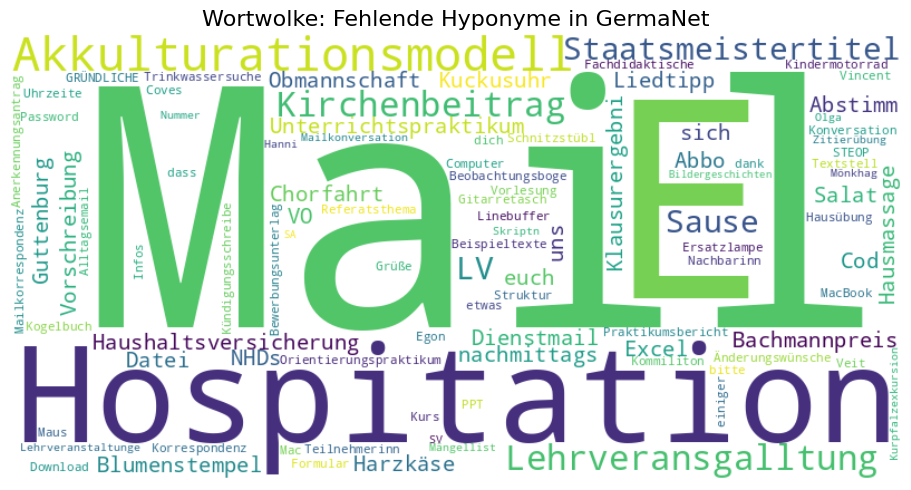

In [ ]:
if missing_hyponyms:
  generate_wordcloud_from_list(missing_hyponyms)
else:
  print("Alle Hyponyme sind in GermaNet vorhanden!")

#### Auswertung von LLaMA-Hyponymen

Die Kategorisierung der vom LLaMA-Modell vorgeschlagenen, aber in GermaNet nicht enthaltenen Hyponyme ermöglicht es, systematische Lücken sowie sprachliche Besonderheiten gezielt zu identifizieren – ein wichtiger Schritt für die lexikalisch-semantische Analyse.

  1. Falsch geschriebene oder unvollständige Wörter  
  Beispiele: `Klausurergebni`, `Teilnehmerinn`, `E-mail`  
  Diese Begriffe weisen Tippfehler, abgeschnittene Endungen oder umgangssprachliche Schreibweisen auf.

2. Abkürzungen  
Beispiele: `LV`, `PPT`, `SV-Nummer`  
Die Begriffe stammen aus spezifischen Kontexten und liegen als Abkürzungen vor, die in dieser Form nicht in GermaNet enthalten sind.

3. Personennamen  
Beispiele: `Sören`, `Vincent`, `Daniel`  
Individuelle Eigennamen werden in GermaNet grundsätzlich nicht erfasst.

4. Technische oder fachspezifische Begriffe  
Beispiele: `MacBook`, `Hadoop`, `Excel-Datei`, `Modulübersicht`  
Diese Begriffe entstammen spezialisierten Domänen wie IT oder Hochschulverwaltung, die außerhalb des Abdeckungsbereichs von GermaNet liegen.

5. Alltagswörter  
Beispiele: `bitte`, `jemand`, `was`, `Infos`  
Solche Wörter besitzen keine klare lexikalische Bedeutung im Sinne der Hypernymie und gelten daher als ungeeignet für die Taxonomiebildung.

6. Zusammengesetzte Nomen  
Beispiele: `Akkulturationsmodell`, `Ersatzlampe`, `Beispieltexte`  
Komplexe Komposita werden oft nicht erkannt, da GermaNet in der Regel nur die Grundformen einzelner Lexeme erfasst.

7. Regionale Begriffe  
Beispiele: `Schnitzstübl`, `Hexenfeuer`, `Mönkhag`  
Diese Begriffe sind vermutlich regional geprägt und werden daher nicht von standardisierten Wortnetzen abgedeckt.

8. Groß- und Kleinschreibung (Case Sensitivity)  
Beispiele: `mail`, `KAFFEE`  
GermaNet ist case-sensitiv. Begriffe wie `Mail` oder `Kaffee` sind zwar enthalten, werden bei abweichender Schreibung jedoch nicht erkannt.

9. Kürzel und hochschulspezifischer Sprachgebrauch (Österreich)  
Beispiele: `VO`, `STEOP`, `Hausübung`, `Vorschreibung`  
Diese Begriffe stammen aus dem österreichischen Hochschulkontext bzw. aus verwaltungsinternem Vokabular und sind nicht Bestandteil von GermaNet.

In [ ]:
total_hyponyms = len(df_combined)
missing_hyponyms_ratio = len(missing_hyponyms) / total_hyponyms if total_hyponyms > 0 else 0
print(f"Anteil fehlender Hyponyme: {missing_hyponyms_ratio:.2%}")

Anteil fehlender Hyponyme: 6.47%


> Die nicht vorkommende Llama-Hyponyme in Germanet vor, werden rausgefiltert

In [ ]:
df_combined_filtered = df_combined[df_combined['hyponymInGermanet'] == True]

### Ergebnisauswertungen

> Eine zentrale Herausforderung bei der Bewertung der von LLaMA generierten Hypernyme mit GermaNet besteht in der Mehrdeutigkeit von Wörtern. Ein vom Modell vorgeschlagenes Hypernym kann zwar in GermaNet enthalten sein, jedoch in einem anderen Bedeutungszweig – und wird dadurch fälschlich als *nicht vorhanden* gewertet.
Wird hingegen der gesamte Bedeutungsraum eines Begriffs (d. h. alle zugehörigen Synsets) berücksichtigt, steigt die Übereinstimmung deutlich – von *18 % auf 30 %*. Dieses Ergebnis verdeutlicht, wie stark die Bewertung vom jeweiligen Kontext abhängt.
Erschwerend kommt hinzu, dass GermaNet insgesamt sehr allgemein und tief hierarchisch strukturiert ist. Viele Begriffe führen in oberen Ebenen zu übergeordneten Kategorien wie *„Objekt“* oder *„Entität“*. Um dennoch eine sinnvolle Vergleichbarkeit zu ermöglichen, wurde die Analyse in diesem Projekt auf *maximal fünf Ebenen* beschränkt.
Ein weiterer Aspekt ist die Synonymverwendung durch LLaMA: Das Modell generiert häufig alternative Begriffe wie *„Botschaft“* für *„Nachricht“*, die zwar semantisch korrekt sind, jedoch nicht explizit als Hypernym in GermaNet erfasst werden.

In [ ]:
total_hypernyms = len(df_combined_filtered)
hypernyms_in_germanet = df_combined_filtered["hypernymInGermanet"].sum()
coverage_rate = (hypernyms_in_germanet / total_hypernyms) * 100 if total_hypernyms > 0 else 0
print(f"Abdeckungsgrad der LLaMA-Hypernyme in GermaNet: {coverage_rate:.2f}%")

Abdeckungsgrad der LLaMA-Hypernyme in GermaNet: 30.83%


In [ ]:
avg_germanet_distance = df_combined_filtered[df_combined_filtered["hypernymInGermanet"]]["Germanet Distanz"].mean()
print(f"Durchschnittliche Distanz in GermaNet für übereinstimmende Hypernyme: {avg_germanet_distance:.2f}")

Durchschnittliche Distanz in GermaNet für übereinstimmende Hypernyme: 2.92


#### Ähnlichkeitsmetriken
> Die von LLaMA generierten Hypernyme werden mit den zugehörigen GermaNet-Ketten verglichen, indem die Kosinus-Ähnlichkeit ihrer Wortbedeutungen berechnet wird. Dazu werden die Begriffe aus beiden Quellen erfasst, mithilfe eines BERT-Modells codiert und ihre Embeddings miteinander verglichen. Auf diese Weise lässt sich ermitteln, inwieweit auch nicht explizit in GermaNet enthaltene LLaMA-Hypernyme semantisch mit den dort strukturierten Begriffen übereinstimmen.

In [ ]:
# Ein vortrainiertes Transformer-Modell laden (auf BERT basierend)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def get_germanet_hypernym_list(df_germanet):
    hypernym_list = df_germanet["GermaNet Hypernym"].astype(str).tolist()
    # Falls Werte kommaseparierte Strings sind, aufsplitten und zu einer flachen Liste umwandeln
    hypernym_list = [word.strip() for sublist in hypernym_list for word in sublist.split(",")]

    # Duplikate entfernen
    hypernym_list = list(set(hypernym_list))

    # "GNROOT" entfernen, falls vorhanden
    if "GNROOT" in hypernym_list:
        hypernym_list.remove("GNROOT")

    return hypernym_list

def handle_empty_list(hypernyms):
    if not hypernyms:
        return None
    return model.encode(hypernyms)

def evaluate_llama_chains(df_llama, germanet):
    """
    Vergleicht die von LLaMA generierten Hypernyme mit den Hypernym-Ketten aus GermaNet
    auf semantischer Ebene mithilfe von Cosinus-Ähnlichkeit.

    :param df_llama: DataFrame mit Spalten "Hyponym" und "Llama Hypernym".
    :param germanet: GermaNet-Instanz zur Abfrage der Synsets und Hypernyme.
    :return: DataFrame mit Cosinus-Ähnlichkeit pro Hyponym zwischen LLaMA- und GermaNet-Hypernymen.
    """
    result = []
    for index, row in df_llama.iterrows():
        hyponym = row["Hyponym"]
        #expected_hypernyms = [h.strip() for h in row["Hypernym_Chain"]]
        hypernym_llama = row["Llama Hypernym"]
        synsets = germanet.get_synsets_by_orthform(hyponym)

        # Prüfen, ob das Hyponym in GermaNet existiert
        if not synsets:
            continue  # Falls nicht vorhanden

        if not synsets:
            result.append({
                "Hyponym": hyponym,
                "Llama Hypernyms": hypernym_llama,
                "GermaNet Hypernyms": None,
                "Cosine Similarity": "0.00"
            })
            continue

        hypernym_germanet = get_hypernym_chain_with_hops(hyponym, germanet) # Hole Hypernyms aus GermaNet
        hypernym_germanet_processed = process_germanet_hypernyms(hypernym_germanet)
        hypernym_germanet_list = get_germanet_hypernym_list(hypernym_germanet_processed)

        # Encode Hypernyms
        emb_1 = handle_empty_list(hypernym_llama)
        emb_2 = handle_empty_list(hypernym_germanet_list)

        if emb_1 is None or emb_2 is None:
            result.append({
                "Hyponym": hyponym,
                "Llama Hypernyms": hypernym_llama,
                "GermaNet Hypernyms": hypernym_germanet_list,
                "Cosine Similarity": "0.00"
            })
            continue

        # Durschnitt EMbeddings, da Shape ungleich
        emb_1_avg = np.mean(emb_1, axis=0)
        emb_2_avg = np.mean(emb_2, axis=0)

        # Cosinus-Ähnlichkeit
        similarity_matrix = cosine_similarity([emb_1_avg], [emb_2_avg])
        average_similarity = similarity_matrix[0][0]

        result.append({
            "Hyponym": hyponym,
            "Llama Hypernyms": hypernym_llama,
            "GermaNet Hypernyms": hypernym_germanet_list,
            "Cosine Similarity": f"{average_similarity:.2f}"
        })

    return pd.DataFrame(result)

In [ ]:
df_evaluated = evaluate_llama_chains(df_llama, germanet)
df_evaluated.head(5)

,Hyponym,Llama Hypernyms,GermaNet Hypernyms,Cosine Similarity
0,Arbeit,"[Tätigkeit, Aktivität, Prozess, Ablauf, Entwic...","[Raum, Arbeit, Eigenschaft, Erwerbsarbeit, Tat...",0.79
1,Hilfe,[Unterstützung],"[Beschaffenheit, Lebewesen, Eigenschaft, Tat, ...",0.60
2,Mail,"[Kommunikation, Austausch]","[Übermittlung, Nachricht, Prozess, kognitives ...",0.63
3,Mutter,"[Elternteil, Familienmitglied, Verwandter]","[geschlechtsspezifisches Lebewesen, Lebewesen,...",0.72
4,Kurs,"[Bildung, Ausbildung]","[Beschaffenheit, Eigenschaft, Marktwert, Markt...",0.69


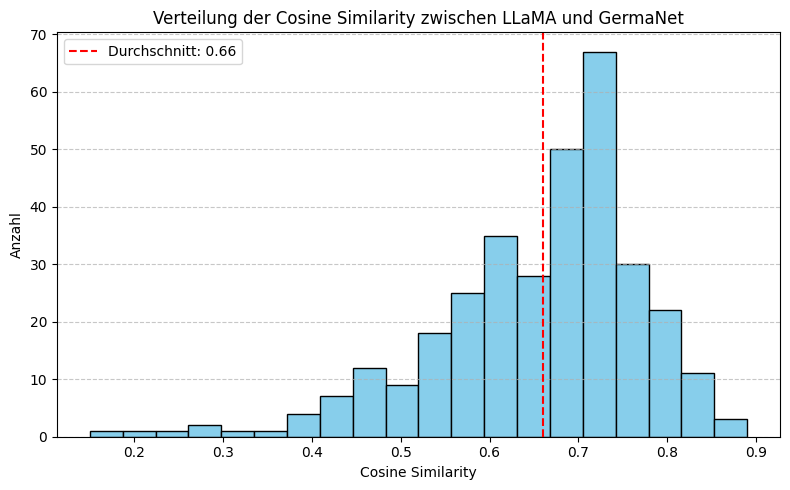

Der berechnete Durchschnitt der Cosine Similarities:  0.66


In [ ]:
def plot_cosine_similarity_distribution(df_similarity):
    """
    Erstellt ein Histogramm der Cosine Similarity-Werte und zeigt den Durchschnittswert an.

    :param df_similarity: DataFrame mit einer Spalte "Cosine Similarity" als String (z. B. "0.82").
    :param show_avg: Gibt an, ob der Durchschnittswert in der Grafik angezeigt werden soll.
    :return: Der berechnete Durchschnitt der Cosine Similarities als float.
    """
    # Umwandlung der Similarity-Spalte in float
    similarities = df_similarity["Cosine Similarity"].astype(float)

    # Durchschnitt berechnen
    avg_similarity = round(similarities.mean(), 2)

    # Histogramm
    plt.figure(figsize=(8, 5))
    plt.hist(similarities, bins=20, color="skyblue", edgecolor="black")
    plt.title("Verteilung der Cosine Similarity zwischen LLaMA und GermaNet")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Anzahl")
    plt.axvline(avg_similarity, color='red', linestyle='--', label=f"Durchschnitt: {avg_similarity}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return avg_similarity

avg = plot_cosine_similarity_distribution(df_evaluated)
print(f"Der berechnete Durchschnitt der Cosine Similarities: ", avg)

> In diesem Schritt wird die Kosinusähnlichkeit berechnet, um zu prüfen, wie stark sich die von LLaMA generierten und die in GermaNet enthaltenen Hypernyme semantisch ähneln – selbst wenn keine exakte Übereinstimmung vorliegt. Der durchschnittliche Ähnlichkeitswert beträgt dabei 66 %, was auf eine inhaltliche Nähe zwischen den beiden Quellen hinweist.

### Analyse von LLama-Hypernyme, die nicht in GermaNet vorhanden

In [ ]:
missing_hypernyms = df_combined_filtered[df_combined_filtered["hypernymInGermanet"] == False]
missing_hypernyms[missing_hypernyms['Llama Rang'] == 1][["Hyponym", "Llama Hypernym"]].sample(50)

,Hyponym,Llama Hypernym
244,Alltag,Erfahrung
23,Rückmeldung,Mitteilung
291,Kostenvoranschlag,Angebot
660,Fragebogen,Frage
53,Film,Kunstwerk
535,Ergebnis,Leistung
14,Kurs,Bildung
993,Organisation,Einrichtung
427,wandern,Bewegung
393,Fehler,Mangel


#### Analyse und Evaluaierung (Stichprobe)


| Hyponym | LLaMA-Hypernym | Bewertung | Begründung |
|-------------------------|------------------------------------|-----------|------------|
| **Rückmeldung** | Mitteilung | Korrekt | Eine spezielle Form der Mitteilung dar |
| **Kostenvoranschlag** | Angebot | Korrekt | Eine bestimmte Art von Angebot |
| **Film** | Kunstwerk | Korrekt | Zählt zu den Kunstwerken |
| **Kurs** | Bildung | Korrekt | Ein Mittel der Bildung |
| **Organisation** | Einrichtung | Korrekt | Eine spezielle Einrichtung |
| **Gottesdienst** | Zeremonie | Korrekt | Eine religiöse Zeremonie |
| **Mangel** | Defizit | Akzeptabel | Ähnliche Bedeutungskategorie |
| **Ergebnis** | Leistung | Teilweise korrekt | Etwa bei sportlichen Leistungen zutreffend |
| **Vernissage** | Feier | Teilweise korrekt | Spezifische Kunstfeier |
| **Fragebogen** | Frage | Falsch | Kein Fragetyp |
| **wandern** | Bewegung | Falsch | Keine Bewegungsart |
| **Fehler** | Mangel | Falsch | Unterschiedliche Konzepte |
| **Glaser** | Hersteller | Falsch | Ein Glaser übt einen Beruf aus, ist kein Hersteller |
| **Griff** | Werkzeug | Falsch |  Keine Unterkategorie |
| **Auspuff** | Fahrzeug | Falsch | Kein Fahrzeugstyp |
| **Flüchtling** | Asylsuchender | Teilweise falsch | Nicht alle Flüchtlinge sind Asylsuchende |

##### Evaluierung (Trefferquote)

| Kategorie | Anzahl | Anteil | Charakteristika | Beispiele |
|-----------|--------|--------|-----------------|-----------|
| **Korrekte Hypernyme** | 7 | 44% | Klare taxonomische Beziehung, präzise Abstraktion | Film→Kunstwerk, Gottesdienst→Zeremonie |
| **Akzeptable Näherungen** | 1 | 6% | Semantisch verwandt, aber keine strikte Taxonomie | Mangel→Defizit |
| **Kontextabhängige Fälle** | 2 | 13% | Nur in spezifischen Domänen gültig | Ergebnis→Leistung (Sport), Vernissage→Feier (Kunst) |
| **Systematische Fehler** | 6 | 37% | Verwechslung fundamentaler Relationen | Griff→Werkzeug (Teil-Ganzes), Glaser→Hersteller (Rollenfehler) |

##### Erkenntnisse und Schluss

LLaMA zeigt gemischte Ergebnisse bei der Generierung von Hypernymen. Grob lässt sich festhalten:

In etwa der Hälfte der Fälle liefert das Modell brauchbare taxonomische Oberbegriffe – insbesondere für konkrete Objektkategorien und institutionelle Begriffe. Dennoch treten typische Schwächen auf:

- Verwechslung von Hypernymie mit Teil-Ganzes-Relationen
- Zu allgemeine oder stark kontextabhängige Vorschläge  
- Unsicherheiten bei Rollenzuweisungen und abstrakten Konzepten

Für den praktischen Einsatz bedeutet das:

- LLaMA eignet sich gut für erste Entwürfe und anwendungsorientierte Szenarien.  
- Für den Aufbau wissenschaftlich belastbarer Taxonomien ist es jedoch ohne menschliche Prüfung nicht zuverlässig genug.

LLaMA kann den Aufbau von Hypernym-Taxonomien sinnvoll unterstützen, ersetzt jedoch keine systematisch kuratierten lexikalischen Ressourcen. Für präzise Anwendungen bleibt eine menschliche Validierung unerlässlich.

---

[TaxoLLaMA](https://huggingface.co/VityaVitalich/TaxoLLaMA) ist ein feinabgestimmtes Modell auf Basis von LLaMA2-7B, das speziell für lexikalisch-semantische Aufgaben mit Fokus auf Taxonomiebildung entwickelt wurde. Es wurde mithilfe von WordNet 3.0 trainiert, um zu gegebenen Hyponymen passende Hyperonyme zu generieren.
Das Fine-Tuning erfolgte mit QLoRA, weshalb lediglich die LoRA-Adapter weitertrainiert werden sollten. Eine zu hohe Lernrate kann zu generischen Textausgaben anstelle von konkreten Hypernymen führen, und auch die gewählte Batchgröße wirkt sich mitunter unvorhersehbar auf die Ausgabequalität aus.
Der Autor empfiehlt ein Few-Shot-Setting als effizienten Ansatz zur Sprachadaption – bereits mit wenigen Beispielen konnten deutliche Verbesserungen erzielt werden.
Bei der Anpassung auf deutsche Daten traten allerdings Formatierungsprobleme auf. Zudem erzeugt das Modell mit den aktuellen Hyperparametern teilweise Synonyme statt echter Hypernyme. Es wurde testweise mit Begriffen aus dem CodEAlltag-Korpus sowie mit GermaNet-Hypernymen weitertrainiert.

**Beispiele aus den TaxoLLaMA-Ausgaben:**

| Hyponym      | LLaMA-Hypernyme                                        | Bewertung und Kommentar                                           |
|--------------|---------------------------------------------------------|-------------------------------------------------------------------|
| **Dame**      | Frau, Individuum, Person                               | sinnvolle Oberbegriffe                  |
| **Frühstück** | Essen, Mahl                                            | sinnvolle Oberbegriffe                    |
| **E-Mail**    | information, communication, message                    | Ausgabe auf Englisch statt auf Deutsch   |
| **Platz**     | Ort, Stelle                                            | Eher Synonyme als Hypernyme |
| **Kaffee**    | '%s','Lebensmittel',['Nahrung','Getränk'    | Formatierungsfehler    |


Aus Zeitgründen lag der Schwerpunkt dieser Arbeit jedoch auf der Arbeit mit LLaMA und der anschließenden Evaluation anhand von GermaNet.

## TaxoLLaMA

In [ ]:
%%time
taxollama_model_name = "VityaVitalich/TaxoLLaMA"
taxollama_model, taxollama_tokenizer = FastLanguageModel.from_pretrained(
    model_name = taxollama_model_name,
    max_seq_length = 256,
    dtype = None,
    load_in_4bit = True
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Load GermaNet data...: 100%|██████████| 100.0/100 [1:46:45<00:00, 64.05s/it]


adapter_model.bin:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

Unsloth 2025.3.19 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


CPU times: user 23.4 s, sys: 20.3 s, total: 43.7 s
Wall time: 34.3 s


In [ ]:
default_system_prompt = """
    Du bist eine Expertin für linguistische Semantik und Taxonomie im Deutschen. Deine Aufgabe ist es, für das folgende deutsche Wort eine Hypernym-Kette zu erstellen.

    Vorgaben:
    - Beginne mit dem konkretesten Begriff (Hyponym).
    - Gehe schrittweise zu immer allgemeineren Begriffen über.
    - Die Begriffe sollen eine nachvollziehbare semantische Hierarchie bilden.
    - Verwende ausschließlich Einzahl (Singular).
    - Gib nur relevante Begriffe aus, keine Erklärungen oder Kommentare.
    - Ausgabeformat: alle Begriffe kommasepariert in einer Zeile, auf Deutsch.
"""
def generate_prompt(user_prompt, hypernyms=""):
    return f"""{default_system_prompt.strip()}

### Instruktion:
{user_prompt.strip()}

### Response:
{hypernyms}
""".strip()

def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    return re.sub(r"\^[^ ]+", "", text)
def formatting_prompts_func(examples):
    instructions = examples["objectlemma"]
    outputs = examples["most_general_hypernyms"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        text = generate_prompt(instruction, output) + taxollama_tokenizer.eos_token
        texts.append(clean_text(text))
    return {"text": texts}

In [ ]:
def process_sample(row):
    word = row['objectlemma']
    # Prüfen, ob das Hyponym in GermaNet existiert
    synsets_hyponym = germanet.get_synsets_by_orthform(word)
    if synsets_hyponym:
      hypernyms_df = get_hypernym_chain_with_hops(word, germanet)

      if not hypernyms_df.empty:
          hypernym_list = hypernyms_df["hypernym"].astype(str).tolist()
          # Falls Werte kommaseparierte Strings sind, aufsplitten und zu einer flachen Liste umwandeln
          hypernym_list = [word.strip() for sublist in hypernym_list for word in sublist.split(",")]
          # Duplikate entfernen
          hypernym_list = list(set(hypernym_list))
          # "GNROOT" entfernen, falls vorhanden
          if "GNROOT" in hypernym_list:
              hypernym_list.remove("GNROOT")
          return hypernym_list
      else:
          return None

In [ ]:
df_train = df[100:].sample(n=100).copy()
df_test = df[100:].sample(n=100).copy()
df_train['most_general_hypernyms'] = df_train.apply(process_sample, axis=1)
df_train.to_json("train_dataset.json", orient="records", lines=True)

In [ ]:
dataset = load_dataset("json", data_files="train_dataset.json", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
dataset["text"][4]

"Du bist eine Expertin für linguistische Semantik und Taxonomie im Deutschen. Deine Aufgabe ist es, für das folgende deutsche Wort eine Hypernym-Kette zu erstellen. Vorgaben: - Beginne mit dem konkretesten Begriff (Hyponym). - Gehe schrittweise zu immer allgemeineren Begriffen über. - Die Begriffe sollen eine nachvollziehbare semantische Hierarchie bilden. - Verwende ausschließlich Einzahl (Singular). - Gib nur relevante Begriffe aus, keine Erklärungen oder Kommentare. - Ausgabeformat: alle Begriffe kommasepariert in einer Zeile, auf Deutsch. ### Instruktion: Portfolio ### Response: ['Teil', 'Gruppe', 'Objekt', 'Sache', 'Listung', 'Gegenstand', 'Entität', 'Liste', 'Formation', 'Gebilde', 'Gruppierung', 'Teilmenge', 'Sammlung', 'Auflistung', 'dingliche Ansammlung', 'Ding']</s>"

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 3,
    warmup_steps = 5,
    max_steps = 20,
    learning_rate = 3e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "outputs",
    report_to = "tensorboard",
)

In [ ]:
trainer = SFTTrainer(
    model = taxollama_model,
    tokenizer = taxollama_tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 256,
    dataset_num_proc = 2,
    packing = False,
    args = training_args
)
trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 3 | Total steps = 20
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 3
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 3 x 1) = 12
 "-____-"     Trainable parameters = 4,194,304/7,000,000,000 (0.06% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.614400
2,2.725900
3,2.582500
4,2.432700
5,2.324600
6,2.125300
7,1.975500
8,1.868300
9,1.700400
10,1.667000


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

TrainOutput(global_step=20, training_loss=1.6901853263378144, metrics={'train_runtime': 27.8468, 'train_samples_per_second': 8.619, 'train_steps_per_second': 0.718, 'total_flos': 2257496399708160.0, 'train_loss': 1.6901853263378144})

In [ ]:
taxollama_model.save_pretrained("taxollama_model")
taxollama_tokenizer.save_pretrained("taxollama_model")

('taxollama_model/tokenizer_config.json',
 'taxollama_model/special_tokens_map.json',
 'taxollama_model/tokenizer.model',
 'taxollama_model/added_tokens.json',
 'taxollama_model/tokenizer.json')

In [ ]:
inference_taxollama_model, inference_taxollama_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "taxollama_model",
    max_seq_length = 256,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(inference_taxollama_model)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (

In [ ]:
def query_hypernyms(word, repetitions=1):
    hypernyms = set()
    user_prompt = f"Generate the hypernym hierarchy for {word}?"
    inputs = inference_taxollama_tokenizer(
        [generate_prompt(user_prompt, hypernyms="")],
        return_tensors="pt"
    ).to("cuda")

    outputs = inference_taxollama_model.generate(
        **inputs,
        top_k=20,
        max_new_tokens=32,
        do_sample=True,
        num_beams=1,
        no_repeat_ngram_size=3,
        num_return_sequences=2,
    )

    raw_output = inference_taxollama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    response = raw_output.split("### Response:")[-1].strip()
    words = [w.strip() for w in response.split(",") if len(w.strip()) > 3 and w!= word]
    hypernyms.update(words)

    return hypernyms # Counter(hypernyms).most_common(1)[0][0] if hypernyms else None

In [ ]:
input_words = df_test['objectlemma'].tolist()
inputs = []
for word in input_words:
  # Prüfen, ob das Hyponym in GermaNet existiert
  synsets_hyponym = germanet.get_synsets_by_orthform(word)
  if not synsets_hyponym:
      continue  # Falls nicht vorhanden
  inputs.append(word)

In [ ]:
results = []
for word in tqdm(inputs, total=len(inputs), desc="Hypernyms Preprocessing"):
    hypernyms = query_hypernyms(word)
    results.append({"Word": word, "Hypernyms": hypernyms})

df_taxo = pd.DataFrame(results)

Hypernyms Preprocessing:   0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
def filter_hypernyms(df):
    filtered_df = df.copy()
    for index, row in df.iterrows():
        word = row['Word']
        hypernyms = row['Hypernyms']
        filtered_hypernyms = [h for h in hypernyms if h != word]
        filtered_df.loc[index, 'Hypernyms'] = filtered_hypernyms
    return filtered_df

df_taxo = filter_hypernyms(df_taxo)
df_taxo

,Word,Hypernyms
0,eislaufen,"['ice skate', 'equipment', 'sport equipment', ..."
1,Haus,"[house, edifice, building unit, structure, bui..."
2,Datum,"[day of week, year, time, year day, singular d..."
3,Vorschlag,"[Vorauslegung, singular: Vorschlagsrede, Vorsc..."
4,Arbeit,"['Einsatz', 'Existenz', 'Tätigkeit', 'Ausübung..."
...,...,...
79,Ergebnis,"[Concept: cognition, Knowledge, Hyponym: Erfah..."
80,Kurs,"[Begriff, singular: Begriff, Begriffe]"
81,Ding,"[singular: Ding, Sach, Gegenständlichkeit, Obj..."
82,Mail,"[hierarchy, semantic hierarchy, semantic, Hypo..."


In [ ]:
# Spalten umbenennen
df_taxo_new = df_taxo.rename(columns={
    "Word": "Hyponym",
    "Hypernyms": "Llama Hypernym"
})

df_taxo_processed = process_llama_hypernyms(df_taxo_new)
df_taxo_combined = combine_llama_and_germanet(df_taxo_processed, germanet)

In [ ]:
total_taxo_hypernyms = len(df_taxo_combined)
hypernyms_taxo_in_germanet = df_taxo_combined["hypernymInGermanet"].sum()
coverage_taxo_rate = (hypernyms_taxo_in_germanet / total_taxo_hypernyms) * 100 if total_taxo_hypernyms > 0 else 0
print(f"Abdeckungsgrad der Taxo-Hypernyme in GermaNet: {coverage_taxo_rate:.2f}%")

Abdeckungsgrad der Taxo-Hypernyme in GermaNet: 6.91%


In [ ]:
avg_taxo_germanet_distance = df_taxo_combined[df_taxo_combined["hypernymInGermanet"]]["Germanet Distanz"].mean()
print(f"Durchschnittliche Distanz in GermaNet für übereinstimmende Hypernyme: {avg_taxo_germanet_distance:.2f}")

Durchschnittliche Distanz in GermaNet für übereinstimmende Hypernyme: 2.95
